In [1]:
using Revise
using LowRankVortex
using LinearAlgebra
using Statistics
using PotentialFlow
using JLD
using Interpolations

┌ Info: Precompiling LowRankVortex [fdf095b8-6f21-420b-9d49-8e692abb03d1]
└ @ Base loading.jl:1664


In [2]:
using Plots

### Configuration setup

In [3]:
# Pressure sensors
Δs = 0.5
sensors = complex.(-2.0:Δs:16.0)
Ny = length(sensors)

Nclusters = 5
# Standard deviation for the radial position of the vortices from the center of the clusters
σr = 0.1
zclusters = [-2.0 + 0.3*im; -1.9 + 1.9*im; -1.8 + 1.1*im; -1.3 + 1.4*im;
             -1.4 + 0.8*im; -1.5 + 1.7*im; -1.2 + 0.2*im]
Nset = 1

config_data = let Nv = Nclusters*Nset, U = complex(1.0), 
             Δt = 1e-3, δ = 1e-1            
    VortexConfig(Nv, U, Δt, δ)
end

Nv = config_data.Nv

xgrid = range(-3, 15, length=100)
ygrid = range(-2.0, 2.0, length=100)

t0 = 0.0
tf = 8.0
tspan = (t0, tf)

(0.0, 8.0)

### Generate the truth used in the twin experiment

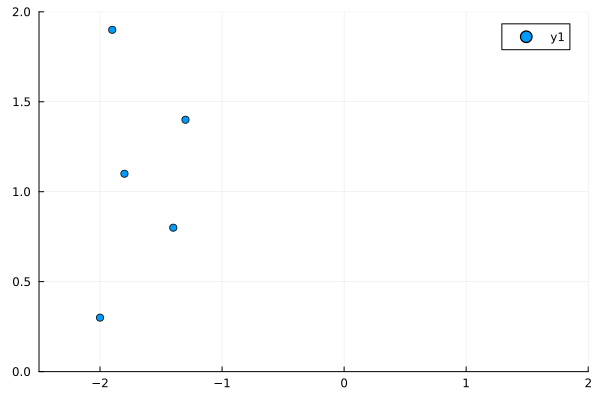

In [4]:
scatter(real.(zclusters)[1:Nclusters], imag.(zclusters)[1:Nclusters], xlims = (-2.5, 2.0), ylims = (0, 2.0))

In [5]:
freestream = Freestream(config_data.U)

Nv = Nclusters*Nset
zv = zeros(ComplexF64, Nv)

for i=1:Nclusters
    for j=1:Nset
#         @show (σr/2 + σr/2*clamp(randn(), -3.0, 3.0)/3.0)
        zv[(i-1)*Nset+j] = zclusters[i] + (σr/2 + σr/2*clamp(randn(), -3.0, 3.0)/3.0)*exp(im*2*π*rand())
    end
end

# zv =  rand(Nv) + 0.8*im*maximum(imag.(config_data.zs))*rand(Nv)
# zv .+= -2.0 + 0.1*im*maximum(imag.(config_data.zs))
Γv = zeros(Nv)
signclusters = [1; 1; 1; 1; 1; 1 ; 1]
Γvmean = [   0.09598711763757772;
             0.3942554457161529;
             0.66223264972610867;
             0.9718197621333651;
             0.7859171016908615;
             0.447930780784646;
             0.5103719570003264]
for i=1:Nclusters
    for j=1:Nset
        Γv[(i-1)*Nset+j] = signclusters[i]*abs.((0.4 + 0.1*randn()))
#         Γv[(i-1)*Nset+j] = signclusters[i]*abs.((Γvmean[i] + 0.1*randn()))
    end
#         Γv[i*Nset] = signclusters[i]*abs.(1.3 + 0.2*randn())
end
# Γv = abs.(randn(Nv))

blobs₊ = Nv >0 ? map(Vortex.Blob, zv, Γv, config_data.δ*ones(Nv)) : Vortex.Blob{Float64, Float64}[]
blobs₋ = Nv >0 ? map(Vortex.Blob, conj.(zv), -Γv, config_data.δ*ones(Nv)) : Vortex.Blob{Float64, Float64}[]

sys = (blobs₊, blobs₋)

#=
#data = generate_data_twin_experiment(deepcopy(sys), t0, tf, config_data, "./data/");
tt, x0, xt, yt = load("./data/data_twin_experiment.jld", "tt", "x0", "xt", "yt")
data = SyntheticData(tt, config_data.Δt, x0, xt, yt)


press_itp = CubicSplineInterpolation((LinRange(real(sensors[1]), real(sensors[end]), length(sensors)),t0:data.Δt:tf), data.yt, extrapolation_bc =  Line())
ytrue(t) = press_itp(real.(sensors), t)
=#

(PotentialFlow.Blobs.Blob{Float64, Float64}[Vortex.Blob(-2.0050952132684774 + 0.33873499462959206im, 0.2665861707351467, 0.1), Vortex.Blob(-1.8256244449163488 + 1.9448827354121039im, 0.4852847924908926, 0.1), Vortex.Blob(-1.7507717128015365 + 1.1001208255256647im, 0.37315291678304946, 0.1), Vortex.Blob(-1.3446451737238747 + 1.3503998056980064im, 0.3228431231793891, 0.1), Vortex.Blob(-1.4405223676254235 + 0.8592452750624041im, 0.4338303473113606, 0.1)], PotentialFlow.Blobs.Blob{Float64, Float64}[Vortex.Blob(-2.0050952132684774 - 0.33873499462959206im, -0.2665861707351467, 0.1), Vortex.Blob(-1.8256244449163488 - 1.9448827354121039im, -0.4852847924908926, 0.1), Vortex.Blob(-1.7507717128015365 - 1.1001208255256647im, -0.37315291678304946, 0.1), Vortex.Blob(-1.3446451737238747 - 1.3503998056980064im, -0.3228431231793891, 0.1), Vortex.Blob(-1.4405223676254235 - 0.8592452750624041im, -0.4338303473113606, 0.1)])

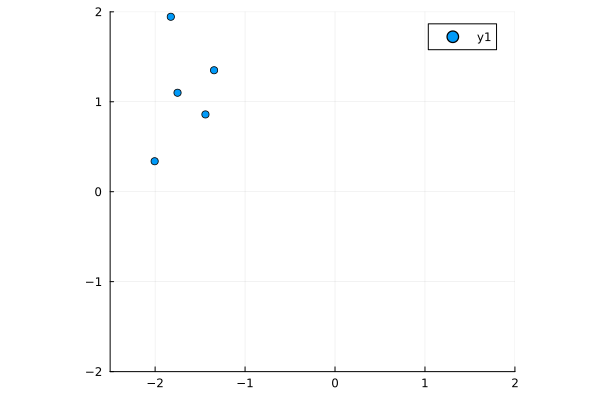

In [6]:
scatter(real.(zv), imag.(zv), xlims = (-2.5, 2.0), ylims = (-2.0, 2.0), ratio = 1.0)

### Setup the sequential filter

In [7]:
config = deepcopy(config_data)

VortexConfig{Nothing}(5, nothing, 1.0 + 0.0im, 0.001, 0.1, true)

In [9]:
Ne = 8
Nx = 3*config.Nv
Ny = length(sensors)

# Generate initial condition
X0 = zeros(Nx, Ne)
zv = zeros(ComplexF64, Nv);
for l=1:Ne
    for i=1:Nclusters
        for j=1:Nset
            zij = zclusters[i] + (σr/2 + σr/2*clamp(randn(), -3.0, 3.0)/3.0)*exp(im*2*π*rand())
            X0[(i-1)*Nset*3 + (j-1)*3 + 1, l] = real(zij)
            X0[(i-1)*Nset*3 + (j-1)*3 + 2, l] = imag(zij)
        end
    end
end

Γv = zeros(Nv)
signclusters = [1; 1; 1; 1; 1; 1 ; 1]

for l = 1:Ne
    for i=1:Nclusters
        for j=1:Nset
            Γij = signclusters[i]*abs.((0.4 + 0.1*randn()))
            X0[(i-1)*Nset*3 + (j-1)*3 + 3, l] = Γij
        end
    end
end


### New ENKF

In [10]:
fdata = SymmetricVortexForecast(config);

In [11]:
odata = SymmetricVortexPressureObservations(sensors,config);

In [12]:
ϵx = 1e-4
ϵy = 1e-4
ϵΓ = 1e-4
ϵmeas = 1e-2

Σϵ = Diagonal(ϵmeas^2*ones(Ny))
Σx = Diagonal(vcat(ϵx^2*ones(Nv),ϵy^2*ones(Nv),ϵΓ^2*ones(Nv)));

In [13]:
x0 = lagrange_to_state(sys,config_data);

In [32]:
#data = generate_data_twin_experiment(x0, t0, tf, config.Δt, fdata, odata, Σx, Σϵ);
#save_synthetic_data(data,"./data/")
data = load_synthetic_data("./data/");

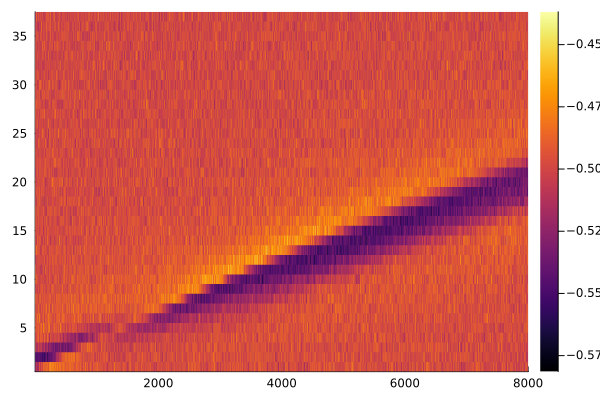

In [32]:
heatmap(data.yt)

In [34]:
ytrue = create_truth_function(data,odata);

In [36]:
#enkf_params2 = StochEnKFParameters(fdata, odata, ytrue, ϵY, config.Δt, config.Δt,islocal=false)
enkf_params2 = StochEnKFParameters(fdata, odata, ytrue, config.Δt, config.Δt,islocal=true,Lyy=0.01,Lxy=0.01)

lrenkf_params2 = LREnKFParameters(fdata, odata, ytrue, config.Δt, config.Δt)

LREnKF with adaptive = true


In [37]:
X = BasicEnsembleMatrix(copy(X0));

In [38]:
Xf, Xa, rxhist, ryhist, Cx_history, Cy_history = enkf(lrenkf_params2,
                                                   X, Σx, Σϵ,
                                                   tspan; β = 1.0);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:17


In [39]:
mean(Xf[end])

15-element Vector{Float64}:
 8.535571154986373
 1.086841106785068
 0.19509607461472378
 6.916783737028065
 1.006385234871125
 0.42468546272036434
 7.831696369733013
 1.4093443724003019
 0.3934649184712476
 7.262852105907799
 1.239494802381119
 0.2516350502543085
 6.718864200521235
 1.4977417014380066
 0.4187894365878305